In [1]:
import torch#, torchvision, torchmetrics
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import tqdm

In [2]:
import uproot
import vector
vector.register_awkward()
import awkward as ak
import pandas as pd
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm

In [9]:
print('Uproot version : ', uproot.__version__)

Uproot version :  5.0.11


In [3]:
if(torch.backends.cuda.is_built()) : 
    device='cuda'
elif(torch.backends.mps.is_built()) : 
    device='mps'
else : 
    device='cpu'

In [4]:
dataset_path = '/Users/sanmay/Documents/ICTS_SCHOOL/Main_School/JetDataset/'
example_file = dataset_path + 'JetClass_example_100k.root' # -- from -- "https://hqu.web.cern.ch/datasets/JetClass/example/" #

In [5]:
# Load the content from the file
tree = uproot.open(example_file)['tree']

In [6]:
tree.num_entries

100000

In [11]:
tree.keys(filter_name='part_*')

['part_px',
 'part_py',
 'part_pz',
 'part_energy',
 'part_deta',
 'part_dphi',
 'part_d0val',
 'part_d0err',
 'part_dzval',
 'part_dzerr',
 'part_charge',
 'part_isChargedHadron',
 'part_isNeutralHadron',
 'part_isPhoton',
 'part_isElectron',
 'part_isMuon']

In [8]:
# Display the content of the "tree"
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
part_px              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_py              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_pz              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_energy          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_deta            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dphi            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0val           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0err           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzval           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzerr           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_charge          | std::

In [12]:
tree.show(filter_name='label_*')

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
label_QCD            | float                    | AsDtype('>f4')
label_Hbb            | bool                     | AsDtype('bool')
label_Hcc            | bool                     | AsDtype('bool')
label_Hgg            | bool                     | AsDtype('bool')
label_H4q            | bool                     | AsDtype('bool')
label_Hqql           | bool                     | AsDtype('bool')
label_Zqq            | int32_t                  | AsDtype('>i4')
label_Wqq            | int32_t                  | AsDtype('>i4')
label_Tbqq           | int32_t                  | AsDtype('>i4')
label_Tbl            | int32_t                  | AsDtype('>i4')


In [13]:
tree.show(filter_name='jet_*')

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
jet_pt               | float                    | AsDtype('>f4')
jet_eta              | float                    | AsDtype('>f4')
jet_phi              | float                    | AsDtype('>f4')
jet_energy           | float                    | AsDtype('>f4')
jet_nparticles       | float                    | AsDtype('>f4')
jet_sdmass           | float                    | AsDtype('>f4')
jet_tau1             | float                    | AsDtype('>f4')
jet_tau2             | float                    | AsDtype('>f4')
jet_tau3             | float                    | AsDtype('>f4')
jet_tau4             | float                    | AsDtype('>f4')


In [14]:
tree.show(filter_name='part_*')

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
part_px              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_py              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_pz              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_energy          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_deta            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dphi            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0val           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0err           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzval           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzerr           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_charge          | std::

In [15]:
# Load all arrays in the tree
# Each array is a column of the table
table = tree.arrays()

In [16]:
# Arrays of a scalar type (bool/int/float) can be converted to a numpy array directly, e.g.
table['label_Hcc'].to_numpy()

array([False, False, False, ..., False, False, False])

In [17]:
np.where(table['label_H4q'].to_numpy()!=0)

(array([40000, 40001, 40002, ..., 49997, 49998, 49999]),)

In [18]:
table['jet_nparticles']

<Array [38, 30, 39, 32, 45, ..., 49, 30, 27, 31, 42] type='100000 * float32'>

In [20]:
feat_list = [ak.flatten(table[part_feat][1000:1001]).to_numpy() for part_feat in tree.keys(filter_name='part_*')]

In [21]:
np.stack(feat_list).T.shape, len(tree.keys(filter_name='part_*'))

((42, 16), 16)

In [22]:
# Construct a Lorentz 4-vector from the (px, py, pz, energy) arrays
p4 = vector.zip({'px': table['part_px'], 'py': table['part_py'], 'pz': table['part_pz'], 'energy': table['part_energy']})

In [23]:
p4.mass

<Array [[0.0442, 0, ..., 0.000345], ..., [...]] type='100000 * var * float32'>

In [20]:
idx=12000
ak.flatten(p4.pt[idx:idx+1]).to_numpy().mean(), ak.flatten(p4.pt[idx:idx+1]).to_numpy().std()

(17.975435, 22.76201)

In [21]:
ak.flatten(p4.phi[idx:idx+1]).to_numpy().mean(), ak.flatten(p4.phi[idx:idx+1]).to_numpy().std()

(-1.5115892, 0.14769214)

In [24]:
jet_sdmass = table['jet_sdmass'].to_numpy()

In [25]:
jet_sdmass_H = jet_sdmass[np.where(table['label_Hbb'].to_numpy()!=0)]
jet_sdmass_T = jet_sdmass[np.where(table['label_Tbqq'].to_numpy()!=0)]

In [26]:
jet_sdmass_H

array([ 91.98812,  17.3149 , 124.49392, ..., 150.37427, 140.32726,
       131.21666], dtype=float32)

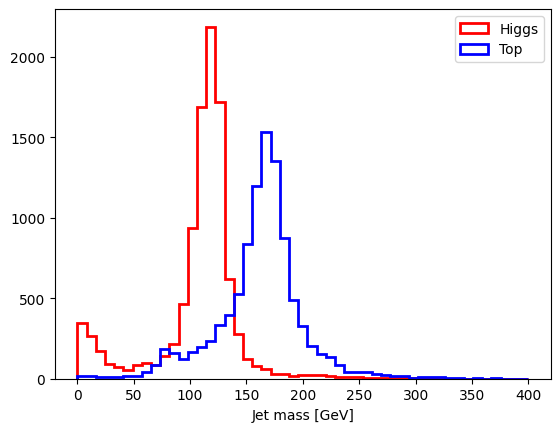

In [27]:
import matplotlib.pyplot as plt
plt.hist(jet_sdmass_H, bins=np.linspace(0, 400, 50), label='Higgs', color='red', histtype='step', linewidth=2.)
plt.hist(jet_sdmass_T, bins=np.linspace(0, 400, 50), label='Top', color='blue', histtype='step', linewidth=2.)
plt.xlabel('Jet mass [GeV]')
plt.legend()
plt.show()

# Let's create a jet dataset 

In [28]:
class Jet_Dataset(data.Dataset):

    def __init__(self, dataset_path:str, tree_name:str = 'tree') -> None:
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        
        
        self.dataset = uproot.open(dataset_path)
        self.tree = self.dataset[tree_name].arrays()
        
        self.num_entries = self.dataset[tree_name].num_entries
        
        self.part_feat = self.dataset[tree_name].keys(filter_name='part_*')
        self.jet_feat = self.dataset[tree_name].keys(filter_name='jet_*')
        self.labels = self.dataset[tree_name].keys(filter_name='labels_*')
        
        
        #self.pc_dataset = [ self.transform_jet_to_point_cloud(idx) for idx in range(self.num_entries-1) ]
        

    def transform_jet_to_point_cloud(self, idx:int) -> dict :
    
        npart = self.tree['jet_nparticles'].to_numpy()[idx:idx+1]
        
        part_feat_list = [ak.flatten(self.tree[part_feat][idx:idx+1]).to_numpy() for part_feat in self.part_feat]
        
        jet_pt = self.tree['jet_pt'].to_numpy()[idx:idx+1]
        jet_eta = self.tree['jet_eta'].to_numpy()[idx:idx+1]
        jet_phi = self.tree['jet_phi'].to_numpy()[idx:idx+1]
        jet_energy = self.tree['jet_energy'].to_numpy()[idx:idx+1]
        jet_tau21 = self.tree['jet_tau2'].to_numpy()[idx:idx+1]/self.tree['jet_tau1'].to_numpy()[idx:idx+1]
        jet_tau32 = self.tree['jet_tau3'].to_numpy()[idx:idx+1]/self.tree['jet_tau2'].to_numpy()[idx:idx+1]
        jet_tau43 = self.tree['jet_tau4'].to_numpy()[idx:idx+1]/self.tree['jet_tau3'].to_numpy()[idx:idx+1]
        
        
        jet_sd_mass = self.tree['jet_sdmass'].to_numpy()[idx:idx+1]
        
        jet_feat = np.stack([jet_pt, jet_eta, jet_phi, jet_energy, jet_tau21, jet_tau32, jet_tau43]).T
              
        jet_feat = np.repeat(jet_feat, int(npart), axis=0)
             
        part_feat = np.stack(part_feat_list).T
        
        total_jet_feat = np.concatenate((part_feat, jet_feat), axis=-1)
        total_jet_feat[np.isnan(total_jet_feat)] = 0.
        
        #print(type(total_jet_feat), 'total_jet_feat shape : ', total_jet_feat.shape)
        
        jet_class = -1
        
        if(self.tree['label_QCD'].to_numpy()[idx:idx+1] == 1) : jet_class = 0
        
        if( (self.tree['label_Tbqq'].to_numpy()[idx:idx+1] == 1) or
            (self.tree['label_Tbl'].to_numpy()[idx:idx+1] == 1)) : jet_class = 3
        
        if( (self.tree['label_Zqq'].to_numpy()[idx:idx+1] == 1) or
            (self.tree['label_Wqq'].to_numpy()[idx:idx+1] == 1)) : jet_class = 2
        
        if( (self.tree['label_Hbb'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_Hcc'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_Hgg'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_H4q'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_Hqql'].to_numpy()[idx:idx+1] == True) ) : jet_class = 1
        
        return {'jet' : torch.tensor(total_jet_feat), 'label' : torch.tensor([jet_class]), 'seq_length' : torch.tensor(npart),
                'sd_mass' : torch.tensor(jet_sd_mass) 
                }     
        

    def __len__(self) -> int:
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.num_entries#len(self.pc_dataset)
    
    def __getitem__(self, idx:int) -> dict :
        # Return the idx-th data point of the dataset
    
        return self.transform_jet_to_point_cloud(idx)#self.pc_dataset[idx]#data_point, data_label


In [29]:
jet_dataset = Jet_Dataset(dataset_path=example_file)

In [30]:
len(jet_dataset)

100000

In [31]:
jet_dataset[16883]['label']

tensor([1])

In [32]:
def create_batch(data_list : list) -> tuple : 
    
    max_length = np.max([ int( data_list[idx]['seq_length'].item() ) for idx in range(len(data_list))  ])
    # print(max_length)
    pc_list, label_list = [], [] 
    
    for idx in range(len(data_list)) : 
        
        
        pc, label = data_list[idx]['jet'], data_list[idx]['label']
        
        N, C = pc.shape[0], pc.shape[1]
        
        pc_padded = torch.zeros([1, max_length, C])
        
        pc = pc.reshape(1, N, C) # (N, C) -> (1, N, C)
        
        pc_padded[:, 0 : N, :   ] = pc[:,:,:] # 
        
        pc_list.append(pc_padded)
        label_list.append( torch.tensor([label]) )
    

    return torch.cat(pc_list, dim=0), torch.cat(label_list, dim=0)

In [33]:
jet_dataloader = data.DataLoader(dataset=jet_dataset, batch_size=5, shuffle=True, collate_fn=create_batch)


In [34]:
jet_data, labels = next(iter(jet_dataloader))

In [35]:
jet_data.shape

torch.Size([5, 40, 23])

In [36]:
from modules.deepsets import DeepSet

In [37]:
model = DeepSet(in_features=23, feats=[25, 20, 15, 10, 6], n_class=4)
model = model.to(device)

In [38]:
y = model(jet_data.to(device))

In [39]:
y.shape, labels.shape

(torch.Size([5, 4]), torch.Size([5]))

## creating the training block

In [45]:
def train(model, device, train_loader, optimizer):
    
    train_loss_ep = 0.
    
    model.train()
    #for batch_idx, (data, target) in enumerate(train_loader):
    with tqdm.tqdm(train_loader, ascii=True) as tq:
        for data, target in tq:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss_ep += loss.item() * data.size(0)
        
    return train_loss_ep

## create the testing block

In [46]:
def test(model, device, test_loader):
    
    test_loss_ep = 0.
    
    model.eval()
    #for batch_idx, (data, target) in enumerate(test_loader):
    with tqdm.tqdm(train_loader, ascii=True) as tq:
        for data, target in tq:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = F.nll_loss(output, target)
            
            test_loss_ep += loss.item() * data.size(0)
        
    return test_loss_ep

# Let's prepare the full dataset and dataloaders

In [41]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 5
# percentage of training set to use as validation
train_size, valid_size = 0.6, 0.2
# # convert data to torch.FloatTensor
# transform = transforms.ToTensor()
# choose the training and testing datasets
# obtain training indices that will be used for validation
jet_dataset = Jet_Dataset(dataset_path=example_file)
num_train = len(jet_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
train_split = int(np.floor(train_size * num_train))
valid_split = int(np.floor(valid_size * num_train))

print(train_split, valid_split)
train_index, valid_index, test_index = indices[0:train_split], indices[train_split:train_split + valid_split], indices[train_split + valid_split:]
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
test_sampler = SubsetRandomSampler(test_index)
# prepare data loaders
train_loader = data.DataLoader(dataset=jet_dataset, batch_size = batch_size, 
                                           num_workers = num_workers, sampler = train_sampler, collate_fn=create_batch)
valid_loader = data.DataLoader(dataset=jet_dataset, batch_size = batch_size,
                                          num_workers = num_workers,  sampler = valid_sampler, collate_fn=create_batch)
test_loader = data.DataLoader(dataset=jet_dataset, batch_size = batch_size,
                                          num_workers = num_workers,  sampler = test_sampler, collate_fn=create_batch)

60000 20000


In [42]:
# - Define the optimizer --- #
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

## Run the training loop 

In [47]:
# number of epochs to train the model
n_epochs = 20
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):
    # monitor losses
    
    train_loss = train(model, device, train_loader, optimizer)
    
    valid_loss = test(model, device, valid_loader)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_jet.pt')
        valid_loss_min = valid_loss

 11%|#1        | 1366/12000 [00:56<06:33, 27.03it/s]/var/folders/27/j7vqc09s6999lx6q2v5txbrm0000gn/T/ipykernel_41598/1360868746.py:37: RuntimeWarning: invalid value encountered in divide
  jet_tau43 = self.tree['jet_tau4'].to_numpy()[idx:idx+1]/self.tree['jet_tau3'].to_numpy()[idx:idx+1]
100%|##########| 12000/12000 [06:54<00:00, 28.92it/s]


Epoch: 1 	Training Loss: 1.190942 	Validation Loss: 3.537704
Validation loss decreased (inf --> 3.537704).  Saving model ...


100%|##########| 12000/12000 [06:45<00:00, 29.62it/s]


Epoch: 2 	Training Loss: 1.173705 	Validation Loss: 3.514536
Validation loss decreased (3.537704 --> 3.514536).  Saving model ...


100%|##########| 12000/12000 [06:37<00:00, 30.22it/s]


Epoch: 3 	Training Loss: 1.164619 	Validation Loss: 3.490329
Validation loss decreased (3.514536 --> 3.490329).  Saving model ...


100%|##########| 12000/12000 [07:03<00:00, 28.35it/s]


Epoch: 4 	Training Loss: 1.161300 	Validation Loss: 3.464391
Validation loss decreased (3.490329 --> 3.464391).  Saving model ...


100%|##########| 12000/12000 [06:48<00:00, 29.39it/s]


Epoch: 5 	Training Loss: 1.159934 	Validation Loss: 3.497932


100%|##########| 12000/12000 [06:47<00:00, 29.48it/s]


Epoch: 6 	Training Loss: 1.159226 	Validation Loss: 3.465642


100%|##########| 12000/12000 [06:36<00:00, 30.29it/s]


Epoch: 7 	Training Loss: 1.156917 	Validation Loss: 3.496719


100%|##########| 12000/12000 [06:50<00:00, 29.20it/s]


Epoch: 8 	Training Loss: 1.157089 	Validation Loss: 3.474123


100%|##########| 12000/12000 [06:36<00:00, 30.28it/s]


Epoch: 9 	Training Loss: 1.156283 	Validation Loss: 3.460565
Validation loss decreased (3.464391 --> 3.460565).  Saving model ...


100%|##########| 12000/12000 [06:40<00:00, 29.93it/s]


Epoch: 10 	Training Loss: 1.154202 	Validation Loss: 3.463111


100%|##########| 12000/12000 [06:37<00:00, 30.19it/s]


Epoch: 11 	Training Loss: 1.153623 	Validation Loss: 3.453419
Validation loss decreased (3.460565 --> 3.453419).  Saving model ...


100%|##########| 12000/12000 [06:50<00:00, 29.27it/s]


Epoch: 12 	Training Loss: 1.153132 	Validation Loss: 3.439516
Validation loss decreased (3.453419 --> 3.439516).  Saving model ...


100%|##########| 12000/12000 [06:50<00:00, 29.24it/s]


Epoch: 13 	Training Loss: 1.152468 	Validation Loss: 3.466441


100%|##########| 12000/12000 [06:57<00:00, 28.76it/s]


Epoch: 14 	Training Loss: 1.152323 	Validation Loss: 3.456443


100%|##########| 12000/12000 [06:49<00:00, 29.27it/s]


Epoch: 15 	Training Loss: 1.150017 	Validation Loss: 3.468603


100%|##########| 12000/12000 [06:43<00:00, 29.71it/s]


Epoch: 16 	Training Loss: 1.150506 	Validation Loss: 3.457710


100%|##########| 12000/12000 [07:15<00:00, 27.55it/s]


Epoch: 17 	Training Loss: 1.148725 	Validation Loss: 3.444675


100%|##########| 12000/12000 [55:15<00:00,  3.62it/s]   


Epoch: 18 	Training Loss: 1.148848 	Validation Loss: 3.427359
Validation loss decreased (3.439516 --> 3.427359).  Saving model ...


100%|##########| 12000/12000 [08:01<00:00, 24.92it/s] 


Epoch: 19 	Training Loss: 1.155505 	Validation Loss: 3.488835


100%|##########| 12000/12000 [06:49<00:00, 29.29it/s]

Epoch: 20 	Training Loss: 1.150035 	Validation Loss: 3.431298


In [50]:
model_test = DeepSet(in_features=23, feats=[25, 20, 15, 10, 6], n_class=4)
model_test.load_state_dict(torch.load('model_jet.pt'))
model_test.to(device)

DeepSet(
  (sequential): ModuleList(
    (0): DeepSetLayer(
      (Gamma): Linear(in_features=23, out_features=25, bias=True)
      (Lambda): Linear(in_features=23, out_features=25, bias=True)
    )
    (1): ReLU()
    (2): DeepSetLayer(
      (Gamma): Linear(in_features=25, out_features=20, bias=True)
      (Lambda): Linear(in_features=25, out_features=20, bias=True)
    )
    (3): ReLU()
    (4): DeepSetLayer(
      (Gamma): Linear(in_features=20, out_features=15, bias=True)
      (Lambda): Linear(in_features=20, out_features=15, bias=True)
    )
    (5): ReLU()
    (6): DeepSetLayer(
      (Gamma): Linear(in_features=15, out_features=10, bias=True)
      (Lambda): Linear(in_features=15, out_features=10, bias=True)
    )
    (7): ReLU()
    (8): DeepSetLayer(
      (Gamma): Linear(in_features=10, out_features=6, bias=True)
      (Lambda): Linear(in_features=10, out_features=6, bias=True)
    )
    (9): DeepSetLayer(
      (Gamma): Linear(in_features=6, out_features=4, bias=True)
    

In [51]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.
    
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            # preds = preds.squeeze(dim=1)
            # preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = torch.argmax(preds, dim=-1) # Binarize predictions to 0 and 10
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [52]:
eval_model(model_test, test_loader)

Accuracy of the model: 50.66%


## What will you do to regress jet mass?